In [ ]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.font_manager as fm 

# Load your dataset
# For simplicity, we assume `df` is your data, with columns like Energy, Saturated Fat, Sugars, Sodium, Protein, Fiber, etc.
df = pd.read_csv('FrozenFood_ExtractedNutrInfo.csv', encoding='utf-8')

df

,樣品名稱,熱量,粗蛋白,粗脂肪,飽和脂肪,總碳水化合物,膳食纖維,糖質總量,鈉,膽固醇,反式脂肪
0,冷凍火腿炒飯,189,5.0,5.6,1.1,29.7,2.0,NaN,220,37.0,NaN
1,冷凍蝦仁炒飯,148,4.7,3.4,0.5,24.6,2.7,1.3,222,11.0,13.41
2,冷凍筒仔米糕,212,6.5,5.8,2.2,33.6,0.7,NaN,331,13.0,NaN
3,冷凍芝麻湯圓,352,4.8,16.3,6.6,46.7,0.9,9.7,3,0.0,69.29
4,冷凍花生湯圓,350,5.2,15.6,7.3,47.1,0.6,9.8,6,0.0,66.28
...,...,...,...,...,...,...,...,...,...,...,...
75,冷凍蟹味棒,118,9.3,0.7,0.2,18.6,NaN,3.1,694,NaN,4.80
76,冷凍魚卵卷,115,12.9,0.2,0.1,15.5,NaN,3.7,830,28.0,6.32
77,冷凍花枝漿,227,11.2,12.6,4.5,17.1,2.0,1.8,637,188.0,NaN
78,冷凍花枝羹,126,11.4,4.7,1.8,9.4,NaN,NaN,448,80.0,NaN


In [2]:
# 使用 FontProperties 建立字體屬性物件
myfont = fm.FontProperties(fname=r'./NotoSansCJK-DemiLight.ttc')

In [3]:
# Function to calculate Health Score Rating (HSR)
def calculate_hsr(row):
    # Example calculation, adjust the logic as per your rating system
    rating = 0
    if row['熱量'] < 400:
        rating += 1
    if row['飽和脂肪'] < 5:
        rating += 1
    if row['糖質總量'] < 20.7:
        rating += 1
    if row['鈉'] < 450:
        rating += 1
    # Additional rating based on Protein and Fiber
    if row['粗蛋白'] > 8:
        rating += 1
    if row['膳食纖維'] > 4.7:
        rating += 1
    return rating

df['HSR'] = df.apply(calculate_hsr, axis=1)

# Sidebar filters
st.sidebar.title('Filter Nutritional Data')
#selected_filter = st.sidebar.selectbox('Select an Item', ['Average', *df['樣品名稱'].unique()])
selected_filter = '冷凍火腿炒飯'

# figure out numeric data for filtering
def data_filter(df, filter_value):
    """
    Returns the data row to be plotted based on filter_value.
    If filter_value is 'Average', returns the average of numeric columns.
    Otherwise, returns the data for the specified filter_value.
    """
    if filter_value == 'Average':
        return df.select_dtypes(include=['number']).mean().round(2)
    else:
        # Filter by selected item and select first numeric row
        filtered_data = df[df['樣品名稱'] == filter_value].select_dtypes(include=['number'])
        if not filtered_data.empty:
            return filtered_data.iloc[0]
        else:
            st.warning("No numeric data available for the selected item.")
            return None

# Get data for filtering
data_filtered = data_filter(df, selected_filter)
data_filtered

2024-11-03 22:00:39.895 
  command:

    streamlit run c:\Users\evele\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


熱量        189.0
粗蛋白         5.0
粗脂肪         5.6
飽和脂肪        1.1
總碳水化合物     29.7
膳食纖維        2.0
糖質總量        NaN
鈉         220.0
膽固醇        37.0
反式脂肪        NaN
HSR         3.0
Name: 0, dtype: float64

In [4]:
def nutr_info():
    dF = pd.DataFrame(data_filtered).reset_index()
    dF.columns = ['Nutrient', selected_filter]

    # Explicitly set the units column as string type
    dF['Unit per 100 g or ml'] = pd.Series(['kcal', 'g', 'g', 'g','g','g','g','g','g','mg', 'Score'])
    
    return dF
    # Display the DataFrame in Streamlit
    # st.sidebar.table(dF.set_index('Nutrient'))

nutr_info()

,Nutrient,冷凍火腿炒飯,Unit per 100 g or ml
0,熱量,189.0,kcal
1,粗蛋白,5.0,g
2,粗脂肪,5.6,g
3,飽和脂肪,1.1,g
4,總碳水化合物,29.7,g
5,膳食纖維,2.0,g
6,糖質總量,NaN,g
7,鈉,220.0,g
8,膽固醇,37.0,g
9,反式脂肪,NaN,mg


In [11]:
def nutr_table():
    dF = nutr_info() # Fetch DataFrame from nutr_info
    
    #Calculate Percent Daily Value
    # Step 1: Extract the selected nutrient values from the DataFrame
    selected_nutrients = ['熱量', '粗蛋白', '飽和脂肪', '膳食纖維', '糖質總量', '鈉']
    NutrTable = dF[dF['Nutrient'].isin(selected_nutrients)].copy().fillna(0)

    
    # Step 2: Define the Daily Recommended Values (DRV)
    DRV = [1800, 65, 20, 25, 45, 2300] #每日飲食建議 31-50歲, 男女不同取稍低活動的中間值
    
    # Step 3a: Calculate Percent Daily Value (PDV) and add it as a new column
    NutrTable['PDV'] = (NutrTable[selected_filter].values / DRV) * 100

    # Step 3b: Round PDV values
    NutrTable['PDV'] = NutrTable['PDV'].round(2).fillna(0)

    return NutrTable

Nutr_Table = nutr_table()
Nutr_Table

,Nutrient,冷凍火腿炒飯,Unit per 100 g or ml,PDV
0,熱量,189.0,kcal,10.50
1,粗蛋白,5.0,g,7.69
3,飽和脂肪,1.1,g,5.50
5,膳食纖維,2.0,g,8.00
6,糖質總量,0.0,g,0.00
7,鈉,220.0,g,9.57


In [12]:
Nutr_Table[selected_filter].values

array([189. ,   5. ,   1.1,   2. ,   0. , 220. ])

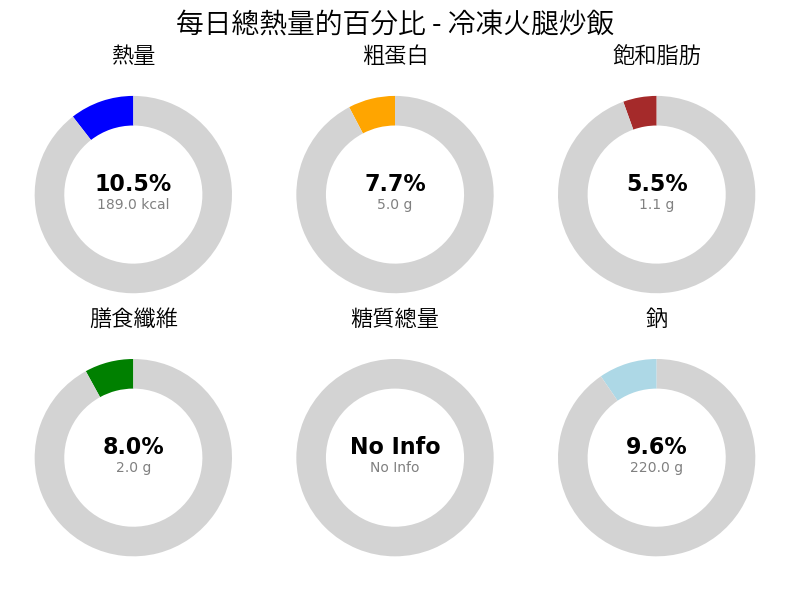

In [18]:
def nutr_graph():
       # Define colors
       bg_color = 'lightgray'
       progress_colors = ['blue', 'orange', 'brown', 'green', 'red', 'lightblue']

       # Create 3x2 grid of subplots
       fig, axes = plt.subplots(2, 3, figsize=(8, 6))
       axes = axes.ravel()  # Flatten axes array for easy indexing

       #Nutr_Table = Nutr_Table.rename(columns={'Unit per 100 g or ml': 'Unit_per_100g_or_ml'})
       Nutr_Table['Unit'] = Nutr_Table['Unit per 100 g or ml']

       for i, row in enumerate(Nutr_Table.itertuples()):
              # Define the value for the progress percentage
              Pvalue = getattr(row, 'PDV') if not pd.isna(getattr(row, 'PDV')) else "0"
              value = getattr(row, selected_filter) if not pd.isna(getattr(row, selected_filter)) else "No Info"
              unit = getattr(row, 'Unit')

              # Plot each nutrient's progress ring
              axes[i].pie(
                     [Pvalue, 100 - Pvalue],
                     startangle=90, 
                     colors=[progress_colors[i], bg_color], 
                     wedgeprops={'width': 0.3}
              )
              # Set title for each subplot with the nutrient name
              axes[i].set_title(row.Nutrient, fontproperties=myfont, fontsize=16) 

              # Annotate the pie chart with two lines in the center
              axes[i].text(
              0, 0.1, f"{Pvalue:.1f}%" if Pvalue != 0 else "No Info",  # The percentage in large font
              ha="center", va="center", fontsize=16, fontweight="bold"
              )
              axes[i].text(
              0, -0.1, f"{value} {unit}" if value != 0 else "No Info",  # The actual value in smaller font
              ha="center", va="center", fontsize=10, color="gray"
              )

       plt.suptitle(f'每日總熱量的百分比 - {selected_filter}', fontproperties=myfont, fontsize=20)
       plt.tight_layout()
       plt.show()

nutr_graph()

In [19]:
def HSR_meter():
    dF = nutr_info() # Fetch DataFrame from nutr_info
    score = dF.loc[dF['Nutrient'] == 'HSR', selected_filter].values[0]

    # Set the meter color based on value
    bar_color = (
        "red" if score <= 1 else
        "orange" if score <= 2 else
        "yellow" if score <= 3 else
        "lightgreen" if score <= 4 else
        "green"
    )

    fig = go.Figure(go.Indicator(
        domain = {'x': [0, 1], 'y': [0, 1]},
        value = score,
        mode = "gauge+number",
        gauge = {'axis': {'range': [None, 5]},
            'bar': {'color': bar_color},
            'steps' : [
                {'range': [0, 2], 'color': "gray"},
                {'range': [2, 3.5], 'color': "lightgray"}]}   
    ))

    # Add a custom title as an annotation beneath the value
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                text="Health Score Value",  # Title text
                x=0.5,  # Centered horizontally
                y=0.5,  # Position it just below the gauge
                showarrow=False,
                font=dict(size=20)
            )
        ]
    )

    fig.show()

HSR_meter()

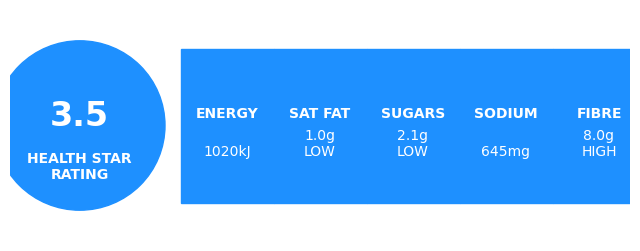

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np

# Define nutritional values
health_star = 3.5
nutrition_info = {
    "ENERGY": "1020kJ",
    "SAT FAT": "1.0g\nLOW",
    "SUGARS": "2.1g\nLOW",
    "SODIUM": "645mg",
    "FIBRE": "8.0g\nHIGH"
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlim(0, 8)
ax.set_ylim(0, 3)
ax.axis('off')

# Draw the star rating section
circle = Circle((0.9, 1.5), 1.1, color='#1E90FF')
ax.add_patch(circle)
ax.text(0.9, 1.5, f"{health_star}", fontsize=24, ha="center", color="white", fontweight="bold")
ax.text(0.9, 0.8, "HEALTH STAR\nRATING", fontsize=10, ha="center", color="white", fontweight="bold")

# Draw nutritional sections
x_start = 2.2
box_width = 1.2

for i, (nutrient, value) in enumerate(nutrition_info.items()):
    rect = Rectangle((x_start + i * box_width, 0.5), box_width, 2, color="#1E90FF")
    ax.add_patch(rect)
    ax.text(x_start + i * box_width + 0.6, 1.6, nutrient, ha="center", fontsize=10, color="white", fontweight="bold")
    ax.text(x_start + i * box_width + 0.6, 1.1, value, ha="center", fontsize=10, color="white")

plt.show()